# Section 2.3. Meta in convolution layer. Test 1

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
import torchvision.transforms as transforms
import numpy as np
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm
import torch.optim as optim
!pip install torchmetrics
import torchmetrics

%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='cifar', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='cifar', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
class Meta(nn.Module):
  def __init__(self, dim_in, dim_out):
    super().__init__()
    self.weight = nn.Parameter(torch.randn((dim_in, dim_out)))

  def forward(self, batch):
    weight = F.softmax(self.weight, 1)
    batch = batch @ self.weight
    return batch

In [5]:
class MyNet_Meta_conv_1(nn.Module):
  def __init__(self):
    super().__init__()
    self.input_filter = nn.Sequential(
        nn.Conv2d(3, 6, 3, padding=1), nn.PReLU(), nn.BatchNorm2d(6),
        nn.Conv2d(6, 16, 3, padding=1), nn.PReLU(), nn.BatchNorm2d(16),
        nn.MaxPool2d(2, 2), nn.Dropout2d(0.1),
    )
    self.convs = nn.ModuleList(
        [nn.Sequential(nn.Conv2d(4, 4, 3, padding=1), nn.PReLU(), nn.BatchNorm2d(4),
        nn.MaxPool2d(2, 2)) for i in range(4)]
    )
    self.hidden_filter = nn.Sequential(
        Meta(4, 8), nn.PReLU(),
    )
    self.out = nn.Sequential(
        nn.Linear(32 * 8 * 8, 40), nn.PReLU(), nn.Dropout(0.2),
        nn.Linear(40, 10)
    )
    
  def forward(self, batch):
    batch = self.input_filter(batch)
    batch = batch.view(batch.shape[0], 4, 4, 16, 16)
    temp = []
    for i, conv in enumerate(self.convs):
      temp.append(conv(batch[:, i]).unsqueeze(-1))
    batch = torch.cat(temp, axis=-1)
    batch = self.hidden_filter(batch)
    batch = batch.flatten(1)
    return self.out(batch)

In [6]:
net = MyNet_Meta_conv_1().to(device)
criterion = torch.nn.CrossEntropyLoss()
metric = torchmetrics.Accuracy().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

In [7]:
summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 32, 32]             168
             PReLU-2            [-1, 6, 32, 32]               1
       BatchNorm2d-3            [-1, 6, 32, 32]              12
            Conv2d-4           [-1, 16, 32, 32]             880
             PReLU-5           [-1, 16, 32, 32]               1
       BatchNorm2d-6           [-1, 16, 32, 32]              32
         MaxPool2d-7           [-1, 16, 16, 16]               0
         Dropout2d-8           [-1, 16, 16, 16]               0
            Conv2d-9            [-1, 4, 16, 16]             148
            PReLU-10            [-1, 4, 16, 16]               1
      BatchNorm2d-11            [-1, 4, 16, 16]               8
        MaxPool2d-12              [-1, 4, 8, 8]               0
           Conv2d-13            [-1, 4, 16, 16]             148
            PReLU-14            [-1, 4,

In [8]:
def train(model, trainloader, testloader, optimizer, criterion, metric, epochs = 10):
  history_loss = []
  history_metrics = []
  history_test_loss = []
  history_test_metrics = []

  for epoch in tqdm(range(epochs)):
    losss = []
    metrics = []
    test_loss = []
    test_metrics = []
    model.train()
    for batch, target in trainloader:
      batch = batch.to(device)
      target = target.to(device)
      optimizer.zero_grad()
      out = model(batch)
      loss = criterion(out, target)
      losss.append(loss.item())
      metrics.append(metric(out, target).item())

      loss.backward()
      optimizer.step()

    model.eval()
    for batch, target in testloader:
      batch = batch.to(device)
      target = target.to(device)
      out = model(batch)
      loss = criterion(out, target)
      test_loss.append(loss.item())
      test_metrics.append(metric(out, target).item())

    history_loss.append(np.mean(losss))
    history_metrics.append(np.mean(metrics))
    history_test_loss.append(np.mean(test_loss))
    history_test_metrics.append(np.mean(test_metrics))
  
  return   history_loss, history_metrics, history_test_loss, history_test_metrics

Обучение завершено
Best accuracy: 0.7039161392405063


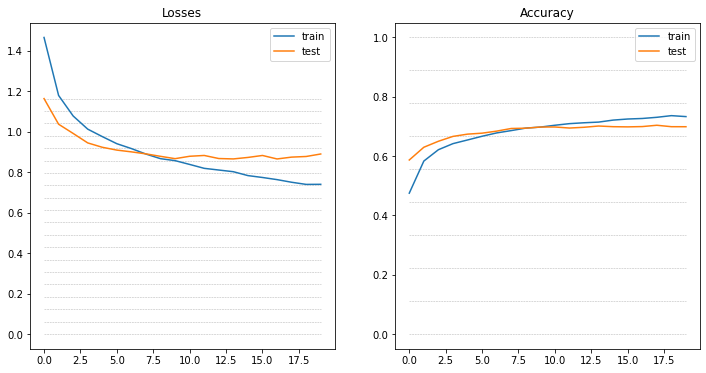

In [9]:
epochs = 20
history_loss, history_metrics, history_test_loss, history_test_metrics = train(net, trainloader, testloader, optimizer, criterion, metric, epochs=epochs)

print("Обучение завершено")
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].set_title("Losses")
ax[0].plot(history_loss, label="train")
ax[0].plot(history_test_loss, label="test")
ax[0].legend()
ax[0].hlines(np.linspace(0, np.max(history_test_loss), epochs), xmin=0, xmax=epochs-1, colors='black', alpha=0.3, linestyles="--", lw=0.5)

ax[1].set_title("Accuracy")
ax[1].plot(history_metrics, label="train")
ax[1].plot(history_test_metrics, label="test")
ax[1].legend()
ax[1].hlines(np.linspace(0, 1, 10), xmin=0, xmax=epochs-1, colors='black', alpha=0.3, linestyles="--", lw=0.5)

print("Best accuracy:",  np.max(history_test_metrics))
plt.show()

# Section 2.3. Meta in convolution layer. Test 2

In [10]:
class MyNet_Meta_conv_2(nn.Module):
  def __init__(self):
    super().__init__()
    self.input_filter = nn.Sequential(
        nn.Conv2d(3, 16, 3, padding=1), nn.PReLU(), nn.BatchNorm2d(16),
        nn.Conv2d(16, 32, 3, padding=1), nn.PReLU(), nn.BatchNorm2d(32),
        nn.MaxPool2d(2, 2), nn.Dropout2d(0.1),
        nn.Conv2d(32, 64, 3, padding=1), nn.PReLU(), nn.BatchNorm2d(64),
    )

    self.convs1 = nn.ModuleList(
        [nn.Sequential(nn.Conv2d(8, 8, 3, padding=1), nn.PReLU(), nn.BatchNorm2d(8)) for i in range(8)]
    )
    self.hidden_filter1 = nn.Sequential(
        Meta(8, 16), nn.PReLU(),
        nn.MaxPool3d(2, 2),
    )

    self.hidden_filter2 = nn.Sequential(
        nn.Conv2d(64, 128, 3, padding=1), nn.PReLU(), nn.BatchNorm2d(128),
    )

    self.convs3 = nn.ModuleList(
        [nn.Sequential(nn.Conv2d(8, 8, 3, padding=1), nn.PReLU(), nn.BatchNorm2d(8)) for i in range(16)]
    )
    self.hidden_filter3 = nn.Sequential(
        Meta(16, 32), nn.PReLU(),
    )

    self.out = nn.Sequential(
        nn.AdaptiveAvgPool3d((4, 3, 3)),
        nn.Flatten(),
        nn.Linear(128 * 3 * 3, 64), nn.PReLU(), nn.Dropout(0.2),
        nn.Linear(64, 10)
    )
    
  def forward(self, batch):
    batch = self.input_filter(batch)
    batch = batch.view(batch.shape[0], 8, 8, 16, 16)
    temp = []
    for i, conv in enumerate(self.convs1):
      temp.append(conv(batch[:, i]).unsqueeze(-1))
    batch = torch.cat(temp, axis=-1)
    batch = self.hidden_filter1(batch)
    batch = batch.view((batch.shape[0], 64, 8, 8))
    batch = self.hidden_filter2(batch)
    batch = batch.view(batch.shape[0], 16, 8, 8, 8)
    temp = []
    for i, conv in enumerate(self.convs3):
      temp.append(conv(batch[:, i]).unsqueeze(-1))
    batch = torch.cat(temp, axis=-1)
    batch = self.hidden_filter3(batch)
    return self.out(batch.transpose(4, 3).transpose(3, 2).transpose(2, 1))

In [11]:
net = MyNet_Meta_conv_2().to(device)
criterion = torch.nn.CrossEntropyLoss()
metric = torchmetrics.Accuracy().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

In [12]:
summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
             PReLU-2           [-1, 16, 32, 32]               1
       BatchNorm2d-3           [-1, 16, 32, 32]              32
            Conv2d-4           [-1, 32, 32, 32]           4,640
             PReLU-5           [-1, 32, 32, 32]               1
       BatchNorm2d-6           [-1, 32, 32, 32]              64
         MaxPool2d-7           [-1, 32, 16, 16]               0
         Dropout2d-8           [-1, 32, 16, 16]               0
            Conv2d-9           [-1, 64, 16, 16]          18,496
            PReLU-10           [-1, 64, 16, 16]               1
      BatchNorm2d-11           [-1, 64, 16, 16]             128
           Conv2d-12            [-1, 8, 16, 16]             584
            PReLU-13            [-1, 8, 16, 16]               1
      BatchNorm2d-14            [-1, 8,

Обучение завершено
Best accuracy: 0.7834256329113924


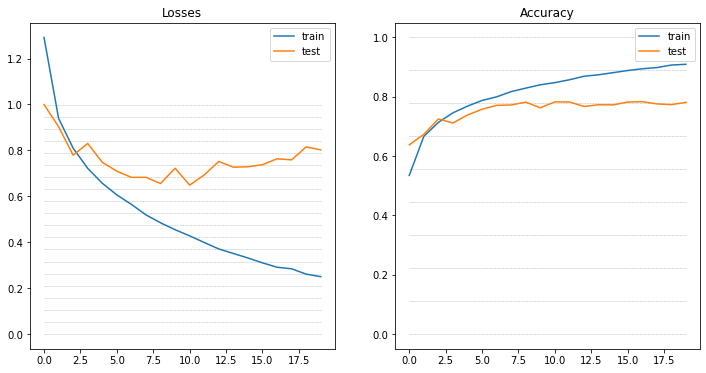

In [13]:
epochs = 20
history_loss, history_metrics, history_test_loss, history_test_metrics = train(net, trainloader, testloader, optimizer, criterion, metric, epochs=epochs)

print("Обучение завершено")
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].set_title("Losses")
ax[0].plot(history_loss, label="train")
ax[0].plot(history_test_loss, label="test")
ax[0].legend()
ax[0].hlines(np.linspace(0, np.max(history_test_loss), epochs), xmin=0, xmax=epochs-1, colors='black', alpha=0.3, linestyles="--", lw=0.5)

ax[1].set_title("Accuracy")
ax[1].plot(history_metrics, label="train")
ax[1].plot(history_test_metrics, label="test")
ax[1].legend()
ax[1].hlines(np.linspace(0, 1, 10), xmin=0, xmax=epochs-1, colors='black', alpha=0.3, linestyles="--", lw=0.5)

print("Best accuracy:",  np.max(history_test_metrics))
plt.show()

# Section 2.3. Meta in convolution layer. Test 3

In [14]:
class ResUnit(nn.Module):
  def __init__(self, dim):
    super().__init__()
    self.dim = dim
    self.convs = nn.ModuleList(
        [nn.Sequential(nn.Conv2d(dim // 8, dim // 8, 3, padding=1), nn.PReLU(), nn.BatchNorm2d(dim // 8)) for i in range(8)]
    )
    self.step1 = nn.Sequential(
        Meta(8, 8), nn.PReLU(),
    )
    self.step2 = nn.Sequential(
        nn.Conv2d(dim, dim, 3, padding=1), nn.PReLU(), nn.BatchNorm2d(dim), nn.Dropout2d(0.1)
    )

  def forward(self, batch):
    batch = batch.view((batch.shape[0], 8, self.dim // 8 , batch.shape[-2], batch.shape[-1]))
    temp = []
    for i, conv in enumerate(self.convs):
      temp.append(conv(batch[:, i]).unsqueeze(-1))
    batch = torch.cat(temp, axis=-1)
    batch = self.step1(batch)
    batch = batch.transpose(4, 3).transpose(3, 2).transpose(2, 1)
    batch = batch.reshape((batch.shape[0], self.dim, batch.shape[-2], batch.shape[-1]))
    return self.step2(batch)

class ResBlock(nn.Module):
  def __init__(self, dim):
    super().__init__()
    self.step = ResUnit(dim)

  def forward(self, batch):
    return batch + self.step(batch)

In [15]:
class MyNet_Meta_conv_3(nn.Module):
  def __init__(self):
    super().__init__()
    self.input_filter = nn.Sequential(
        nn.Conv2d(3, 16, 3, padding=1), nn.PReLU(), nn.BatchNorm2d(16),
        nn.Conv2d(16, 32, 3, padding=1), nn.PReLU(), nn.BatchNorm2d(32),
        nn.MaxPool2d(2, 2), nn.Dropout2d(0.1),
    )
    self.first_process = nn.ModuleList(
        ResBlock(32) for i in range(16)
    )
    self.reshape = nn.Sequential(
        nn.Conv2d(32, 64, 3, padding=1), nn.PReLU(), nn.BatchNorm2d(64), nn.MaxPool2d(2, 2)
    )
    self.second_process = nn.ModuleList(
        ResBlock(64) for i in range(16)
    )
    self.out = nn.Sequential(
        nn.AdaptiveAvgPool2d((4, 4)), nn.Flatten(1),
        nn.Linear(64 * 4 * 4, 64), nn.PReLU(), nn.Dropout(0.2),
        nn.Linear(64, 10)
    )

  def forward(self, batch):
    prepared_batch = self.input_filter(batch)
    for block in self.first_process:
      prepared_batch = block(prepared_batch)

    reshaped_batch = self.reshape(prepared_batch)
    for block in self.second_process:
      reshaped_batch = block(reshaped_batch)

    return self.out(reshaped_batch)


In [16]:
net = MyNet_Meta_conv_3().to(device)
criterion = torch.nn.CrossEntropyLoss()
metric = torchmetrics.Accuracy().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

In [17]:
summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
             PReLU-2           [-1, 16, 32, 32]               1
       BatchNorm2d-3           [-1, 16, 32, 32]              32
            Conv2d-4           [-1, 32, 32, 32]           4,640
             PReLU-5           [-1, 32, 32, 32]               1
       BatchNorm2d-6           [-1, 32, 32, 32]              64
         MaxPool2d-7           [-1, 32, 16, 16]               0
         Dropout2d-8           [-1, 32, 16, 16]               0
            Conv2d-9            [-1, 4, 16, 16]             148
            PReLU-10            [-1, 4, 16, 16]               1
      BatchNorm2d-11            [-1, 4, 16, 16]               8
           Conv2d-12            [-1, 4, 16, 16]             148
            PReLU-13            [-1, 4, 16, 16]               1
      BatchNorm2d-14            [-1, 4,

Обучение завершено
Best accuracy: 0.8296083860759493


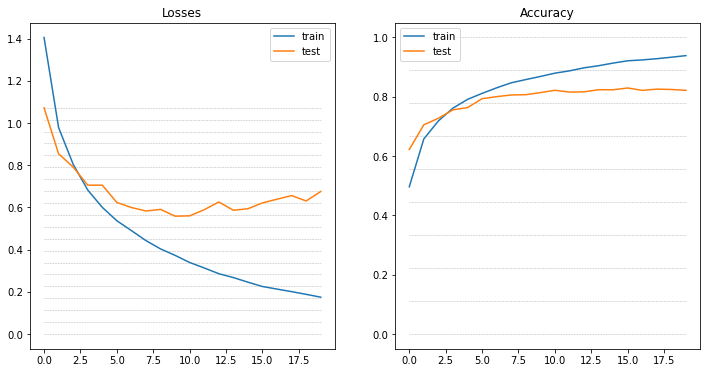

In [18]:
epochs = 20
history_loss, history_metrics, history_test_loss, history_test_metrics = train(net, trainloader, testloader, optimizer, criterion, metric, epochs=epochs)

print("Обучение завершено")
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].set_title("Losses")
ax[0].plot(history_loss, label="train")
ax[0].plot(history_test_loss, label="test")
ax[0].legend()
ax[0].hlines(np.linspace(0, np.max(history_test_loss), epochs), xmin=0, xmax=epochs-1, colors='black', alpha=0.3, linestyles="--", lw=0.5)

ax[1].set_title("Accuracy")
ax[1].plot(history_metrics, label="train")
ax[1].plot(history_test_metrics, label="test")
ax[1].legend()
ax[1].hlines(np.linspace(0, 1, 10), xmin=0, xmax=epochs-1, colors='black', alpha=0.3, linestyles="--", lw=0.5)

print("Best accuracy:",  np.max(history_test_metrics))
plt.show()